In [143]:
%load_ext autoreload
%autoreload 2
from common import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [154]:
RESULT_JSON = "/Users/law/repos/viper/results/kv_size/all_kv_size.json"

In [155]:
FIXTURES = [VIPER, DRAM_MAP, HYBRID_FASTER, NVM_FASTER]
BM_TYPES = ['insert', 'get']

BMS = get_all_runs(RESULT_JSON)
# pprint(BMS) 

KV_SIZE_RE = re.compile(r".*KeyType(\d+),ValueType(\d+).*")

def get_kv_size(bm_name):
    match = KV_SIZE_RE.match(bm_name)
    if match is None:
        raise f"unknown kv size: {bm_name}"
    return (int(match.group(1)), int(match.group(2)))

RUNS = defaultdict(list)

for bm in BMS:
    bm_type = get_bm_type(bm['name'])
    kv_size = get_kv_size(bm['name'])
    RUNS[(kv_size, bm_type)].append(bm)
        
    for _, run in RUNS.items():
        run.sort(key=lambda x: x['name'], reverse=True) 
        
pprint(RUNS)

defaultdict(<class 'list'>,
            {((8, 8), 'get'): [{'cpu_time': 2304597.148361111,
                                'items_per_second': 21644750.684584226,
                                'iterations': 36,
                                'name': 'ViperFixture<KeyType8,ValueType8>/get_8_8/1250000000/50000000/iterations:1/repeats:1/real_time/threads:36',
                                'real_time': 64167.4288717583,
                                'repetition_index': 0,
                                'repetitions': 1,
                                'run_name': 'ViperFixture<KeyType8,ValueType8>/get_8_8/1250000000/50000000/iterations:1/repeats:1/real_time/threads:36',
                                'run_type': 'iteration',
                                'threads': 36,
                                'time_unit': 'us'},
                               {'cpu_time': 44753343.672361106,
                                'items_per_second': 1107775.116799715,
                          

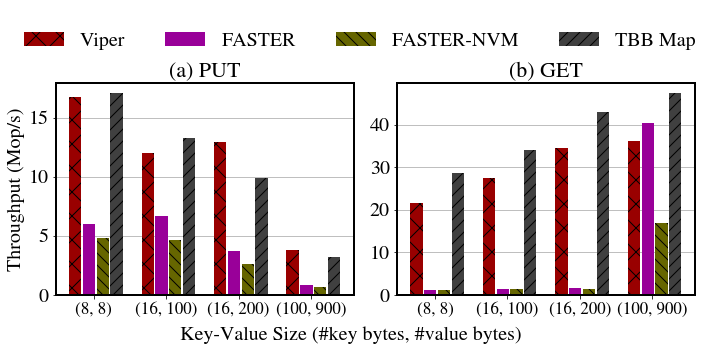

In [158]:
fig, (insert_ax, get_ax) = plt.subplots(1, 2, figsize=(10, 4))

def get_bm_ax(bm_type):
    if bm_type == 'insert': return insert_ax
    if bm_type == 'get': return get_ax
    raise RuntimeError(f"Unknown bm_type {bm_type}")
    
KV_SIZES = sorted({kv_size for (kv_size, _) in RUNS.keys()})
SORTED_FIXTURES = sorted(FIXTURES, key=lambda f: f[0], reverse=True)

# Set position of bar on X axis
bar_width = 0.17
bar_diff = 0.02
r1 = np.arange(len(KV_SIZES))
r2 = [x + bar_width + bar_diff for x in r1]
r3 = [x + bar_width + bar_diff for x in r2]
r4 = [x + bar_width + bar_diff for x in r3]

HATCHES = ['//', '', '\\\\', 'x']

for bm_type, letter in zip(BM_TYPES, ['a', 'b']):
    ax = get_bm_ax(bm_type)
#     ax.set_xlabel("Key-Value Size\n(#key bytes, #value bytes)", fontsize=20)
    ax.set_title(f"({letter}) {bm_type.upper()}", fontsize=22)

    for i, kv_size in enumerate(KV_SIZES):
        r = [run['items_per_second'] / MILLION for run in RUNS[(kv_size, bm_type)]]
        for f_id, (val, pos) in enumerate(zip(r, [r1, r2, r3, r4])):
            fixture = SORTED_FIXTURES[f_id]
            style = STYLES[fixture[0]]
#             ax.bar(pos[i], val, bar_width, bottom=0, color='white', edgecolor=style.color, linewidth=2, hatch=style.hatch)
            ax.bar(pos[i], val, bar_width, bottom=0, color=style.color, hatch=style.hatch)
        ax.set_xticks([r + (1.5 * bar_width) for r in range(len(KV_SIZES))])
        ax.set_xticklabels(KV_SIZES)

    ax.set_axisbelow(True)
    ax.grid(axis='y', which='major')
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(17)
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(20)


insert_ax.set_ylabel("Throughput (Mop/s)", fontsize=20)
insert_ax.set_title(f"(a) PUT", fontsize=22)

fig.legend(loc='upper center', labels=[f[1] for f in SORTED_FIXTURES], 
           bbox_to_anchor=(0.5, 1.17), ncol=4, frameon=False, fontsize=20)
# plt.xlabel("Key-Value Size\n(#key bytes, #value bytes)", fontsize=20)
fig.text(0.5, -0.02, 'Key-Value Size (#key bytes, #value bytes)', ha='center', fontsize=20)

fig.savefig('charts/kv_size.pdf', bbox_inches='tight')
fig.savefig('charts/kv_size.svg', bbox_inches='tight')